# Main Paper Figures

This notebook contains all the data and plotting logic for the figures in the paper:
**"The surprising interpretability of vision tokens in LLMs"**

Each section contains:
1. The raw data needed for the plot
2. The plotting code

This notebook is self-contained and reproducible.


In [1]:
# Setup and imports
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
from pathlib import Path

# Set default style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'sans-serif'

# Output directory for figures
OUTPUT_DIR = Path('paper_figures_output')
OUTPUT_DIR.mkdir(exist_ok=True)
print(f"Figures will be saved to: {OUTPUT_DIR.absolute()}")


Figures will be saved to: /content/paper_figures_output


---
## Figure 1: Unified Interpretability Line Plot

Three-panel figure showing interpretability across layers for:
- (a) Nearest Neighbors (static V-Lens at input layer)
- (b) Logit Lens
- (c) Contextual NN (contextual V-Lens)

Each panel shows 9 model combinations (3 LLMs × 3 vision encoders).


In [ ]:
# =============================================================================
# LOAD DATA from data.json (auto-generated by update_data.py)
# Run: python update_data.py   to refresh data from analysis_results/
# =============================================================================
import json
import urllib.request

DATA_URL = "https://raw.githubusercontent.com/BennoKrojer/molmo/interp/paper_plots/data.json"

def load_data():
    """Load data from local file or GitHub."""
    try:
        with open('data.json', 'r') as f:
            print("✓ Loaded from local data.json")
            return json.load(f)
    except FileNotFoundError:
        pass
    try:
        with urllib.request.urlopen(DATA_URL) as r:
            print("✓ Loaded from GitHub")
            return json.loads(r.read().decode())
    except Exception as e:
        print(f"⚠ Could not load data: {e}")
        return None

def fix_keys(d):
    """Convert string keys to int for layer numbers."""
    return {k: {int(layer): v for layer, v in layers.items()} for k, layers in d.items()}

_data = load_data()
if _data:
    NN_DATA = fix_keys(_data['nn'])
    LOGITLENS_DATA = fix_keys(_data['logitlens'])
    CONTEXTUAL_DATA = fix_keys(_data['contextual'])
    # Filter to only 9 main model combos
    MAIN_MODELS = [f"{l}+{e}" for l in ['olmo-7b','llama3-8b','qwen2-7b'] for e in ['vit-l-14-336','siglip','dinov2-large-336']]
    CONTEXTUAL_DATA = {k:v for k,v in CONTEXTUAL_DATA.items() if k in MAIN_MODELS}
    print(f"  NN: {len(NN_DATA)}, LogitLens: {len(LOGITLENS_DATA)}, Contextual: {len(CONTEXTUAL_DATA)} models")
else:
    raise RuntimeError("Could not load data!")


In [ ]:
# =============================================================================
# PLOTTING CONFIG: Colors, markers, labels, expected layers
# =============================================================================

# Display names for paper
LLM_DISPLAY_NAMES = {
    'llama3-8b': 'Llama3-8B',
    'olmo-7b': 'OLMo-7B',
    'qwen2-7b': 'Qwen2-7B'
}

ENCODER_DISPLAY_NAMES = {
    'vit-l-14-336': 'CLIP ViT-L/14',
    'siglip': 'SigLIP',
    'dinov2-large-336': 'DINOv2'
}

# Order for consistent legend
LLM_ORDER = ['olmo-7b', 'llama3-8b', 'qwen2-7b']
ENCODER_ORDER = ['vit-l-14-336', 'siglip', 'dinov2-large-336']

# Color scheme: each LLM gets a color family, encoders get shades
LLM_BASE_COLORS = {
    'olmo-7b': plt.cm.Blues,
    'llama3-8b': plt.cm.Greens,
    'qwen2-7b': plt.cm.Reds
}
ENCODER_SHADE_INDICES = [0.5, 0.7, 0.9]

# Markers for each encoder
ENCODER_MARKERS = {
    'vit-l-14-336': '*',       # star (filled)
    'siglip': 'o',             # circle (hollow)
    'dinov2-large-336': '^'    # triangle (filled)
}
ENCODER_MARKER_FACECOLORS = {
    'vit-l-14-336': None,      # filled
    'siglip': 'none',          # hollow
    'dinov2-large-336': None   # filled
}

# =============================================================================
# EXPECTED LAYERS: [0, 1, 2, 4, 8, 16, 24, N-2, N-1] where N varies per LLM
# =============================================================================

def get_expected_layers(llm):
    """
    Get the expected layers for a given LLM.
    We use: [0, 1, 2, 4, 8, 16, 24, N-2, N-1]
    where N = 32 for OLMo/Llama, N = 28 for Qwen
    """
    if llm in ['olmo-7b', 'llama3-8b']:
        return [0, 1, 2, 4, 8, 16, 24, 30, 31]
    elif llm == 'qwen2-7b':
        return [0, 1, 2, 4, 8, 16, 24, 26, 27]
    else:
        return [0, 1, 2, 4, 8, 16, 24, 30, 31]

def get_all_expected_layers():
    """Get union of all expected layers across all models."""
    return sorted(set(get_expected_layers('olmo-7b') + get_expected_layers('qwen2-7b')))

def filter_to_expected_layers(data):
    """Filter data to only include expected layers for each model."""
    filtered = {}
    for key, layer_data in data.items():
        llm = key.split('+')[0]
        expected = set(get_expected_layers(llm))
        filtered[key] = {k: v for k, v in layer_data.items() if k in expected}
    return filtered

# =============================================================================

def get_color_map():
    """Generate color mapping for all model combinations."""
    color_map = {}
    for llm in LLM_ORDER:
        base_cmap = LLM_BASE_COLORS[llm]
        for enc_idx, encoder in enumerate(ENCODER_ORDER):
            color_map[(llm, encoder)] = base_cmap(ENCODER_SHADE_INDICES[enc_idx])
    return color_map

def parse_model_key(key):
    """Parse 'llm+encoder' string into (llm, encoder) tuple."""
    parts = key.split('+')
    return parts[0], parts[1]

def get_display_label(llm, encoder):
    """Get display label for legend."""
    llm_label = LLM_DISPLAY_NAMES.get(llm, llm)
    encoder_label = ENCODER_DISPLAY_NAMES.get(encoder, encoder)
    return f"{llm_label} + {encoder_label}"


In [ ]:
# =============================================================================
# PLOTTING FUNCTION: Unified 3-panel figure
# =============================================================================

def create_unified_lineplot(nn_data, logitlens_data, contextual_data,
                            output_path=None, figsize=(18, 5)):
    """
    Create unified figure with 3 subplots showing interpretability across layers.

    Args:
        nn_data: Dict of nearest neighbors data
        logitlens_data: Dict of logit lens data
        contextual_data: Dict of contextual NN data
        output_path: Path to save figure (optional)
        figsize: Figure size tuple
    """
    color_map = get_color_map()
    
    # Filter data to expected layers and get x-axis ticks
    nn_data = filter_to_expected_layers(nn_data)
    logitlens_data = filter_to_expected_layers(logitlens_data)
    contextual_data = filter_to_expected_layers(contextual_data)
    all_expected_layers = get_all_expected_layers()

    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    subplot_configs = [
        {'ax': axes[0], 'data': nn_data, 'title': 'Input Embedding Matrix', 'xlabel': 'Layer'},
        {'ax': axes[1], 'data': logitlens_data, 'title': 'Output Embedding Matrix (Logitlens)', 'xlabel': 'Layer'},
        {'ax': axes[2], 'data': contextual_data, 'title': 'LN-Lens', 'xlabel': 'Layer'},
    ]

    handles_dict = {}

    for config in subplot_configs:
        ax = config['ax']
        data = config['data']

        if not data:
            continue

        # Plot lines for each model combination
        for llm in LLM_ORDER:
            for encoder in ENCODER_ORDER:
                key = f"{llm}+{encoder}"
                if key not in data:
                    continue

                layer_data = data[key]
                layers = sorted(layer_data.keys())
                values = [layer_data[l] for l in layers]

                if len(layers) == 0:
                    continue

                label = get_display_label(llm, encoder)
                marker = ENCODER_MARKERS.get(encoder, 'o')
                marker_facecolor = ENCODER_MARKER_FACECOLORS.get(encoder)
                color = color_map[(llm, encoder)]

                if marker_facecolor is not None:
                    line, = ax.plot(layers, values, marker=marker, color=color,
                                   markerfacecolor=marker_facecolor,
                                   markeredgewidth=2, linewidth=2.5, markersize=10)
                else:
                    line, = ax.plot(layers, values, marker=marker, color=color,
                                   linewidth=2.5, markersize=10)

                if label not in handles_dict:
                    handles_dict[label] = line

        # Customize subplot
        ax.set_xlabel(config['xlabel'], fontsize=14, fontweight='bold')
        ax.set_ylabel('Interpretable Tokens %\n(via automated judge)', fontsize=14, fontweight='bold')
        ax.set_title(config['title'], fontsize=16, fontweight='bold', pad=10)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 100)
        ax.tick_params(axis='both', labelsize=11)

        # Set x-axis to show only expected layers
        ax.set_xlim(min(all_expected_layers) - 0.5, max(all_expected_layers) + 0.5)
        ax.set_xticks(all_expected_layers)
        ax.set_xticklabels([str(t) for t in all_expected_layers])

    # Create shared legend at bottom
    ordered_handles = []
    ordered_labels = []
    for llm in LLM_ORDER:
        for encoder in ENCODER_ORDER:
            label = get_display_label(llm, encoder)
            if label in handles_dict:
                ordered_handles.append(handles_dict[label])
                ordered_labels.append(label)

    fig.legend(ordered_handles, ordered_labels,
              loc='lower center',
              bbox_to_anchor=(0.5, -0.12),
              ncol=3,
              fontsize=12,
              framealpha=0.9,
              columnspacing=2.0,
              handlelength=2.5)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.22, wspace=0.25)

    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {output_path}")
        # Also save PNG
        png_path = Path(output_path).with_suffix('.png')
        plt.savefig(png_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {png_path}")

    plt.show()
    return fig


Saved: paper_figures_output/fig1_unified_interpretability.pdf
Saved: paper_figures_output/fig1_unified_interpretability.png


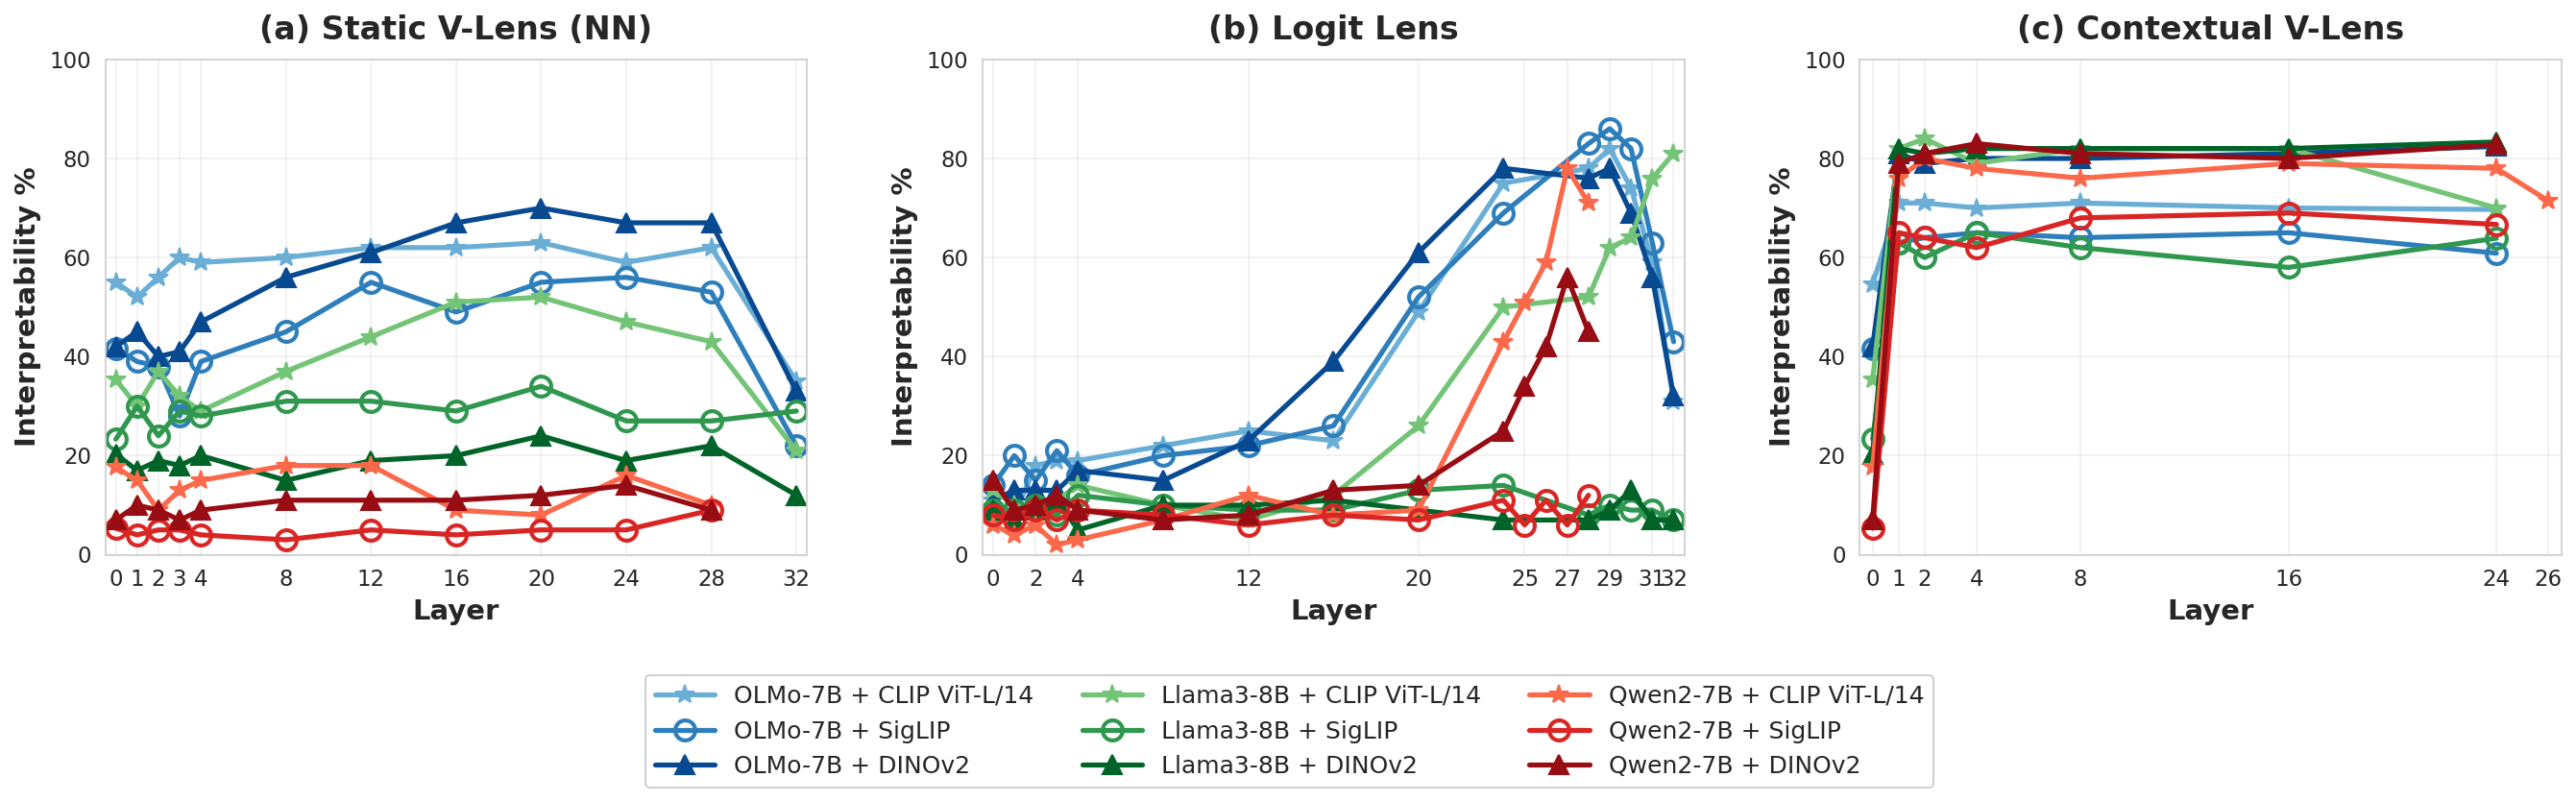

In [ ]:
# Generate Figure 1: Unified interpretability plot
interp_output_dir = OUTPUT_DIR / 'interpretability'
interp_output_dir.mkdir(exist_ok=True)

fig1 = create_unified_lineplot(
    NN_DATA,
    LOGITLENS_DATA,
    CONTEXTUAL_DATA,
    output_path=interp_output_dir / 'fig1_unified_interpretability.pdf'
)


---
## Figure 2: Baselines Plot (NN + LogitLens)

Two-panel figure showing baseline methods.


In [ ]:
def create_baselines_lineplot(nn_data, logitlens_data, output_path=None, figsize=(24, 8)):
    """
    Create a figure with 2 subplots side by side for baselines (NN and LogitLens).
    Matches create_lineplot_unified.py create_baselines_lineplot()
    """
    color_map = get_color_map()
    
    # Filter data to expected layers
    nn_data = filter_to_expected_layers(nn_data)
    logitlens_data = filter_to_expected_layers(logitlens_data)
    all_expected_layers = get_all_expected_layers()

    fig, axes = plt.subplots(1, 2, figsize=figsize)

    subplot_configs = [
        {'ax': axes[0], 'data': nn_data, 'title': 'Input Embedding Matrix', 'xlabel': 'Layer'},
        {'ax': axes[1], 'data': logitlens_data, 'title': 'Output Embedding Matrix (Logitlens)', 'xlabel': 'Layer'},
    ]

    handles_dict = {}

    for config in subplot_configs:
        ax = config['ax']
        data = config['data']

        if not data:
            continue

        for llm in LLM_ORDER:
            for encoder in ENCODER_ORDER:
                key = f"{llm}+{encoder}"
                if key not in data:
                    continue

                layer_data = data[key]
                layers = sorted(layer_data.keys())
                values = [layer_data[l] for l in layers]

                if len(layers) == 0:
                    continue

                label = get_display_label(llm, encoder)
                marker = ENCODER_MARKERS.get(encoder, 'o')
                marker_facecolor = ENCODER_MARKER_FACECOLORS.get(encoder)
                color = color_map[(llm, encoder)]

                if marker_facecolor is not None:
                    line, = ax.plot(layers, values, marker=marker, color=color,
                                   markerfacecolor=marker_facecolor,
                                   markeredgewidth=2, linewidth=2.5, markersize=10)
                else:
                    line, = ax.plot(layers, values, marker=marker, color=color,
                                   linewidth=2.5, markersize=10)

                if label not in handles_dict:
                    handles_dict[label] = line

        ax.set_xlabel(config['xlabel'], fontsize=16, fontweight='bold')
        ax.set_ylabel('Interpretable Tokens %\n(via automated judge)', fontsize=14, fontweight='bold')
        ax.set_title(config['title'], fontsize=18, fontweight='bold', pad=15)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 100)
        ax.tick_params(axis='both', labelsize=12)

        ax.set_xlim(min(all_expected_layers) - 0.5, max(all_expected_layers) + 0.5)
        ax.set_xticks(all_expected_layers)
        ax.set_xticklabels([str(t) for t in all_expected_layers])

    # Shared legend
    ordered_handles = []
    ordered_labels = []
    for llm in LLM_ORDER:
        for encoder in ENCODER_ORDER:
            label = get_display_label(llm, encoder)
            if label in handles_dict:
                ordered_handles.append(handles_dict[label])
                ordered_labels.append(label)

    fig.legend(ordered_handles, ordered_labels,
              loc='lower center', bbox_to_anchor=(0.5, -0.08),
              ncol=3, fontsize=15, framealpha=0.9,
              columnspacing=2.5, handlelength=2.5, handletextpad=1.2)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.20, wspace=0.25)

    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {output_path}")
        png_path = Path(output_path).with_suffix('.png')
        plt.savefig(png_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {png_path}")

    plt.show()
    return fig


In [ ]:
# Generate Figure 2: Baselines plot (NN + LogitLens)
fig_baselines = create_baselines_lineplot(
    NN_DATA,
    LOGITLENS_DATA,
    output_path=interp_output_dir / 'fig_baselines.pdf'
)


In [ ]:
---
## Figure 3: LN-Lens Plot (Our Method)

Single plot showing our LN-Lens method.


In [ ]:
def create_lnlens_lineplot(contextual_data, output_path=None, figsize=(12, 8)):
    """
    Create a single figure for LN-Lens (our method).
    Matches create_lineplot_unified.py create_lnlens_lineplot()
    """
    color_map = get_color_map()
    
    # Filter to expected layers
    contextual_data = filter_to_expected_layers(contextual_data)
    all_expected_layers = get_all_expected_layers()

    fig, ax = plt.subplots(figsize=figsize)

    handles_dict = {}

    if contextual_data:
        for llm in LLM_ORDER:
            for encoder in ENCODER_ORDER:
                key = f"{llm}+{encoder}"
                if key not in contextual_data:
                    continue

                layer_data = contextual_data[key]
                layers = sorted(layer_data.keys())
                values = [layer_data[l] for l in layers]

                if len(layers) == 0:
                    continue

                label = get_display_label(llm, encoder)
                marker = ENCODER_MARKERS.get(encoder, 'o')
                marker_facecolor = ENCODER_MARKER_FACECOLORS.get(encoder)
                color = color_map[(llm, encoder)]

                if marker_facecolor is not None:
                    line, = ax.plot(layers, values, marker=marker, color=color,
                                   markerfacecolor=marker_facecolor,
                                   markeredgewidth=2, linewidth=2.5, markersize=10)
                else:
                    line, = ax.plot(layers, values, marker=marker, color=color,
                                   linewidth=2.5, markersize=10)

                if label not in handles_dict:
                    handles_dict[label] = line

    ax.set_xlabel('Layer', fontsize=16, fontweight='bold')
    ax.set_ylabel('Interpretable Tokens %\n(via automated judge)', fontsize=14, fontweight='bold')
    ax.set_title('LN-Lens', fontsize=18, fontweight='bold', pad=15)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 100)
    ax.tick_params(axis='both', labelsize=12)

    ax.set_xlim(min(all_expected_layers) - 0.5, max(all_expected_layers) + 0.5)
    ax.set_xticks(all_expected_layers)
    ax.set_xticklabels([str(t) for t in all_expected_layers])

    # Legend
    ordered_handles = []
    ordered_labels = []
    for llm in LLM_ORDER:
        for encoder in ENCODER_ORDER:
            label = get_display_label(llm, encoder)
            if label in handles_dict:
                ordered_handles.append(handles_dict[label])
                ordered_labels.append(label)

    ax.legend(ordered_handles, ordered_labels,
              loc='lower right', ncol=1, fontsize=12, framealpha=0.9)

    plt.tight_layout()

    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {output_path}")
        png_path = Path(output_path).with_suffix('.png')
        plt.savefig(png_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {png_path}")

    plt.show()
    return fig


In [ ]:
# Generate Figure 3: LN-Lens plot (our method)
fig_lnlens = create_lnlens_lineplot(
    CONTEXTUAL_DATA,
    output_path=interp_output_dir / 'fig_lnlens.pdf'
)


---
## Figure 4: Token Similarity Across Layers

3x3 grid showing how vision and text tokens evolve through LLM layers.
Y-axis: Cosine similarity to Layer 0 (input layer).


In [ ]:
# Load token similarity data
if _data and 'token_similarity' in _data:
    TOKEN_SIM_DATA = _data['token_similarity']
    # Convert string keys to int
    for modality in ['vision', 'text']:
        TOKEN_SIM_DATA[modality] = {
            k: {int(layer): v for layer, v in layers.items()}
            for k, layers in TOKEN_SIM_DATA[modality].items()
        }
    print(f"✓ Loaded token similarity data: Vision {len(TOKEN_SIM_DATA['vision'])}, Text {len(TOKEN_SIM_DATA['text'])} models")
else:
    print("⚠ No token_similarity data in data.json")


In [ ]:
def create_token_similarity_plot(token_sim_data, output_path=None, figsize=(16, 12)):
    """
    Create 3x3 token similarity plot.
    Matches create_token_similarity_plots.py create_combined_3x3_plot()
    """
    llm_order = ['olmo-7b', 'llama3-8b', 'qwen2-7b']
    enc_order = ['vit-l-14-336', 'siglip', 'dinov2-large-336']
    
    fig, axes = plt.subplots(3, 3, figsize=figsize)
    
    vision_data = token_sim_data['vision']
    text_data = token_sim_data['text']
    
    for row, llm in enumerate(llm_order):
        for col, encoder in enumerate(enc_order):
            ax = axes[row, col]
            key = f"{llm}+{encoder}"
            
            if key not in vision_data and key not in text_data:
                ax.set_visible(False)
                continue
            
            # Vision tokens
            if key in vision_data:
                vision_layers = sorted(vision_data[key].keys())
                vision_sim = [vision_data[key][l] for l in vision_layers]
                ax.plot(vision_layers, vision_sim, marker='o', linewidth=2.5, markersize=8,
                       label='Vision tokens', color='#2E86AB', alpha=0.8)
            
            # Text tokens
            if key in text_data:
                text_layers = sorted(text_data[key].keys())
                text_sim = [text_data[key][l] for l in text_layers]
                ax.plot(text_layers, text_sim, marker='s', linewidth=2.5, markersize=8,
                       label='Text tokens', color='#A23B72', alpha=0.8)
            
            # Title
            title = f'{LLM_DISPLAY_NAMES.get(llm, llm)} + {ENCODER_DISPLAY_NAMES.get(encoder, encoder)}'
            ax.set_title(title, fontsize=16, fontweight='bold', pad=10)
            
            # Labels (only on edges)
            if col == 0:
                ax.set_ylabel('Cosine Similarity\nto Layer 0', fontsize=15)
            if row == 2:
                ax.set_xlabel('LLM Layer', fontsize=15)
            
            # Styling
            ax.grid(True, alpha=0.3, linestyle='--')
            ax.set_ylim(0, 1.05)
            ax.tick_params(labelsize=12)
    
    # Global legend
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.subplots_adjust(right=0.98, hspace=0.35, wspace=0.25, top=0.88, bottom=0.12)
    
    middle_subplot = axes[1, 1]
    bbox = middle_subplot.get_position()
    middle_col_center_x = bbox.x0 + bbox.width / 2
    
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(middle_col_center_x, 0.02),
              ncol=2, fontsize=17, framealpha=0.9, columnspacing=2.0, handlelength=2.0)
    
    fig.suptitle('Same-Token Similarity Across LLM Layers', fontsize=20, fontweight='bold', y=0.95)
    
    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        plt.savefig(Path(output_path).with_suffix('.pdf'), dpi=300, bbox_inches='tight')
        print(f"✓ Saved: {output_path}")
    
    plt.show()
    return fig


In [ ]:
# Generate Figure 4: Token Similarity plot
token_sim_output_dir = OUTPUT_DIR / 'token_similarity_plots'
token_sim_output_dir.mkdir(exist_ok=True)

fig_token_sim = create_token_similarity_plot(
    TOKEN_SIM_DATA,
    output_path=token_sim_output_dir / 'token_similarity_combined_3x3.png'
)


---
## Data Tables

Print the data in tabular format for reference.


In [ ]:
def print_data_table(data, title):
    """Print data in a formatted table."""
    print(f"\n{'='*80}")
    print(f"{title}")
    print(f"{'='*80}")

    # Get all layers
    all_layers = set()
    for key, layer_data in data.items():
        all_layers.update(layer_data.keys())
    all_layers = sorted(list(all_layers))

    # Print header
    print(f"{'Model':<35}", end="")
    for layer in all_layers:
        print(f"{'L'+str(layer):>7}", end="")
    print()
    print("-" * (35 + len(all_layers) * 7))

    # Print data
    for llm in LLM_ORDER:
        for encoder in ENCODER_ORDER:
            key = f"{llm}+{encoder}"
            if key not in data:
                continue
            label = get_display_label(llm, encoder)
            print(f"{label:<35}", end="")
            for layer in all_layers:
                value = data[key].get(layer)
                if value is not None:
                    print(f"{value:>6.1f}%", end="")
                else:
                    print(f"{'---':>7}", end="")
            print()

print_data_table(NN_DATA, "Static V-Lens (Nearest Neighbors) Data")
print_data_table(LOGITLENS_DATA, "Logit Lens Data")
print_data_table(CONTEXTUAL_DATA, "Contextual V-Lens Data")


---
## Summary Statistics


In [ ]:
def compute_summary_stats(data, name):
    """Compute summary statistics for a dataset."""
    print(f"\n{name}:")
    print("-" * 50)

    for llm in LLM_ORDER:
        for encoder in ENCODER_ORDER:
            key = f"{llm}+{encoder}"
            if key not in data:
                continue
            values = list(data[key].values())
            label = get_display_label(llm, encoder)
            print(f"  {label}:")
            print(f"    Layer 0: {data[key].get(0, 'N/A'):.1f}%" if 0 in data[key] else "    Layer 0: N/A")
            print(f"    Max: {max(values):.1f}% | Min: {min(values):.1f}% | Mean: {np.mean(values):.1f}%")

compute_summary_stats(NN_DATA, "Static V-Lens")
compute_summary_stats(LOGITLENS_DATA, "Logit Lens")
compute_summary_stats(CONTEXTUAL_DATA, "Contextual V-Lens")


---
## Key Findings

Summary of main observations from the data.


---
## Layer Alignment Heatmaps

Shows vision layer (Y) vs LLM layer (X) alignment as heatmaps.
Color intensity = normalized proportion of top-5 NNs from that LLM layer.


In [ ]:
# Layer alignment heatmap configuration
LLM_DISPLAY_HEATMAP = {
    'olmo-7b': 'OLMo-7B',
    'llama3-8b': 'Llama3-8B', 
    'qwen2-7b': 'Qwen2-7B'
}
ENC_DISPLAY_HEATMAP = {
    'vit-l-14-336': 'CLIP',
    'siglip': 'SigLIP',
    'dinov2-large-336': 'DINOv2'
}

# Fixed layer configurations per LLM (for consistent axes)
VISION_LAYERS_DEFAULT = [0, 1, 2, 4, 8, 16, 24, 30, 31]  # OLMo, Llama
VISION_LAYERS_QWEN = [0, 1, 2, 4, 8, 16, 24, 26, 27]     # Qwen

LLM_LAYERS_DEFAULT = [1, 2, 4, 8, 16, 24, 30, 31]  # OLMo, Llama (32 layers)
LLM_LAYERS_QWEN = [1, 2, 4, 8, 16, 24, 26, 27]     # Qwen (28 layers)

def get_fixed_layers(llm):
    """Get fixed vision and LLM layers based on LLM type."""
    if 'qwen' in llm.lower():
        return VISION_LAYERS_QWEN, LLM_LAYERS_QWEN
    else:
        return VISION_LAYERS_DEFAULT, LLM_LAYERS_DEFAULT


In [ ]:
def create_single_heatmap(counts, llm, encoder, output_path=None):
    """Create a single heatmap for one model combination."""
    vision_layers, llm_layers = get_fixed_layers(llm)
    n_vision = len(vision_layers)
    n_llm = len(llm_layers)
    
    # Build the matrix: rows = vision layers (Y), cols = LLM layers (X)
    matrix = np.zeros((n_vision, n_llm))
    
    for i, vl in enumerate(vision_layers):
        vl_str = str(vl)
        layer_counts = counts.get(vl_str, {})
        total = sum(layer_counts.values())
        if total > 0:
            for j, ll in enumerate(llm_layers):
                ll_str = str(ll)
                matrix[i, j] = layer_counts.get(ll_str, 0) / total
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Heatmap with pcolormesh for cell borders
    # Fixed 0-1 color range for comparability
    im = ax.pcolormesh(matrix, cmap='viridis', vmin=0, vmax=1.0,
                       edgecolors='black', linewidth=0.5)
    ax.set_aspect('auto')
    
    # Labels
    ax.set_xlabel('LLM Layer', fontsize=18)
    ax.set_ylabel('Vision Layer', fontsize=18)
    ax.set_title(f'{LLM_DISPLAY_HEATMAP.get(llm, llm)} + {ENC_DISPLAY_HEATMAP.get(encoder, encoder)}',
                 fontsize=20, fontweight='bold', pad=15)
    
    # Y-axis: vision layers (ticks at cell centers: 0.5, 1.5, ...)
    ax.set_yticks([i + 0.5 for i in range(n_vision)])
    ax.set_yticklabels([str(vl) for vl in vision_layers], fontsize=15)
    
    # X-axis: LLM layers (ticks at cell centers)
    ax.set_xticks([i + 0.5 for i in range(n_llm)])
    ax.set_xticklabels([str(ll) for ll in llm_layers], fontsize=15)
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Proportion of Top-5 NNs', fontsize=16)
    cbar.ax.tick_params(labelsize=15)
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        plt.savefig(Path(output_path).with_suffix('.pdf'), dpi=300, bbox_inches='tight')
        print(f"✓ Saved: {output_path}")
    
    plt.show()
    return fig


In [ ]:
def create_combined_3x3_heatmap(all_counts, output_path=None):
    """Create combined 3x3 heatmap figure."""
    llm_order = ['olmo-7b', 'llama3-8b', 'qwen2-7b']
    enc_order = ['vit-l-14-336', 'siglip', 'dinov2-large-336']
    
    fig, axes = plt.subplots(3, 3, figsize=(14, 10))
    
    # Build matrices for all models
    all_matrices = {}
    
    for llm in llm_order:
        vision_layers, llm_layers = get_fixed_layers(llm)
        n_vision = len(vision_layers)
        n_llm = len(llm_layers)
        
        for encoder in enc_order:
            key = f"{llm}+{encoder}"
            counts = all_counts.get(key, {})
            if not counts:
                continue
            
            matrix = np.zeros((n_vision, n_llm))
            for i, vl in enumerate(vision_layers):
                vl_str = str(vl)
                layer_counts = counts.get(vl_str, {})
                total = sum(layer_counts.values())
                if total > 0:
                    for j, ll in enumerate(llm_layers):
                        ll_str = str(ll)
                        matrix[i, j] = layer_counts.get(ll_str, 0) / total
            
            all_matrices[key] = (matrix, vision_layers, llm_layers)
    
    images = []
    for row, llm in enumerate(llm_order):
        for col, encoder in enumerate(enc_order):
            ax = axes[row, col]
            key = f"{llm}+{encoder}"
            
            if key not in all_matrices:
                ax.set_visible(False)
                continue
            
            matrix, vision_layers, llm_layers = all_matrices[key]
            n_vision = len(vision_layers)
            n_llm = len(llm_layers)
            
            # Heatmap with pcolormesh for cell borders, fixed 0-1 color range
            im = ax.pcolormesh(matrix, cmap='viridis', vmin=0, vmax=1.0,
                              edgecolors='black', linewidth=0.3)
            ax.set_aspect('auto')
            images.append(im)
            
            # Title
            title = f'{LLM_DISPLAY_HEATMAP.get(llm, llm)} + {ENC_DISPLAY_HEATMAP.get(encoder, encoder)}'
            ax.set_title(title, fontsize=16, fontweight='bold', pad=10)
            
            # Y-axis labels (ticks at cell centers, only leftmost column shows labels)
            ax.set_yticks([i + 0.5 for i in range(n_vision)])
            if col == 0:
                ax.set_yticklabels([str(vl) for vl in vision_layers], fontsize=12)
                ax.set_ylabel('Vision Layer', fontsize=15)
            else:
                ax.set_yticklabels([])
            
            # X-axis labels - show on ALL subplots since LLM layers differ per model
            ax.set_xticks([i + 0.5 for i in range(n_llm)])
            ax.set_xticklabels([str(ll) for ll in llm_layers], fontsize=12)
            if row == 2:
                ax.set_xlabel('LLM Layer', fontsize=15)
    
    # Single colorbar for all
    # Adjust spacing: more vertical space, lower top to accommodate suptitle, more bottom space for x-labels
    fig.subplots_adjust(right=0.88, hspace=0.35, wspace=0.15, top=0.88, bottom=0.08)
    cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(images[0], cax=cbar_ax)
    cbar.set_label('Proportion of Top-5 NNs', fontsize=16)
    cbar.ax.tick_params(labelsize=15)
    
    fig.suptitle('Vision Token → LLM Layer Alignment', fontsize=20, fontweight='bold', y=0.95)
    
    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        plt.savefig(Path(output_path).with_suffix('.pdf'), dpi=300, bbox_inches='tight')
        print(f"✓ Saved: {output_path}")
    
    plt.show()
    return fig


In [ ]:
# Load layer alignment data
if _data and 'layer_alignment' in _data:
    LAYER_ALIGNMENT_DATA = _data['layer_alignment']
    print(f"✓ Loaded layer alignment data for {len(LAYER_ALIGNMENT_DATA)} model combinations")
    
    # Create combined 3x3 heatmap
    heatmap_output_dir = OUTPUT_DIR / 'layer_alignment_heatmaps'
    heatmap_output_dir.mkdir(exist_ok=True)
    combined_path = heatmap_output_dir / 'heatmap_combined_3x3.png'
    
    create_combined_3x3_heatmap(LAYER_ALIGNMENT_DATA, output_path=combined_path)
else:
    print("⚠ No layer_alignment data found in data.json")
